In [9]:
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

caffe.set_mode_cpu()

import numpy as npc
from pylab import *
%matplotlib inline
import tempfile

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [10]:
# Download just a small subset of the data for this exercise.
# (2000 of 80K images, 5 of 20 labels.)
# To download the entire dataset, set `full_dataset = True`.
full_dataset = False
if full_dataset:
    NUM_STYLE_IMAGES = NUM_STYLE_LABELS = -1
else:
    NUM_STYLE_IMAGES = 2000
    NUM_STYLE_LABELS = 5

# This downloads the ilsvrc auxiliary data (mean file, etc),
# and a subset of 2000 images for the style recognition task.
import os
os.chdir(caffe_root)  # run scripts from caffe root
!data/ilsvrc12/get_ilsvrc_aux.sh
!scripts/download_model_binary.py models/bvlc_reference_caffenet
!python examples/finetune_flickr_style/assemble_data.py \
    --workers=-1  --seed=1701 \
    --images=$NUM_STYLE_IMAGES  --label=$NUM_STYLE_LABELS
# back to examples
os.chdir('examples')

Downloading...
wget: /root/anaconda2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/anaconda2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2017-06-10 06:45:45--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: ‘caffe_ilsvrc12.tar.gz’

100%[======================================>] 17,858,008  3.02MB/s   in 13s    

2017-06-10 06:45:58 (1.31 MB/s) - ‘caffe_ilsvrc12.tar.gz’ saved [17858008/17858008]

Unzipping...
Done.
Model already exists.
Writing train/val for 2000 successfully downloaded images.


In [13]:
import os
weights = os.path.join(caffe_root, 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
assert os.path.exists(weights)

In [14]:
# Load ImageNet labels to imagenet_labels
imagenet_label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000
print 'Loaded ImageNet labels:\n', '\n'.join(imagenet_labels[:10] + ['...'])

# Load style labels to style_labels
style_label_file = caffe_root + 'examples/finetune_flickr_style/style_names.txt'
style_labels = list(np.loadtxt(style_label_file, str, delimiter='\n'))
if NUM_STYLE_LABELS > 0:
    style_labels = style_labels[:NUM_STYLE_LABELS]
print '\nLoaded style labels:\n', ', '.join(style_labels)

Loaded ImageNet labels:
n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
n01496331 electric ray, crampfish, numbfish, torpedo
n01498041 stingray
n01514668 cock
n01514859 hen
n01518878 ostrich, Struthio camelus
...

Loaded style labels:
Detailed, Pastel, Melancholy, Noir, HDR


In [15]:
from caffe import layers as L, params as P

In [16]:
weight_param  = dict(lr_mult=1,decay_mult=1)
bias_param = dict(lr_mult=2,decay_mult=0)
learned_param = [weight_param,bias_param]

frozen_param = [dict(lr_mult=0)]*2

In [17]:
def conv_relu(bottom,ks,nout,stride=1,pad=0,group=1,
             param=learned_param,
             weight_filler=dict(type="gaussian",std=0.01),
             bias_filler=dict(type="constant",value=0.1)):
    conv = L.Convolution(bottom,kernel_size=ks,stride=stride,
                        num_output=nout,pad=pad,group=group,
                        param=param,weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return conv,L.ReLU(conv,in_place=True)

In [18]:
def fc_relu(bottom,nout,param=learned_param,
           weight_filler=dict(type="gaussian",std=0.005),
           bias_filler=dict(type="constant",value=0.1)):
    fc = L.InnerProduct(bottom,num_output=nout,param=param,
                       weight_filler=weight_filler,
                       bias_filler=bias_filler)
    return fc,L.ReLU(fc,in_place=True)

In [19]:
def max_pool(bottom,ks,stride=1):
    return L.Pooling(bottom,pool=P.Pooling.MAX,kernel_size=ks,stride=stride)

In [20]:
def caffenet(data,label=None,train=True,num_classes=1000,
            classifier_name="fc8",learn_all=False):
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param  #use lr>0 or lr=0 to control 
    n.conv1,n.relu1 = conv_relu(n.data,11,96,stride=4,param=param)
    n.pool1 = max_pool(n.relu1,3,stride=2)
    n.norm1 = L.LRN(n.pool1,local_size=5,alpha=1e-4,beta=0.75)
    n.conv2,n.relu2 = conv_relu(n.norm1,5,256,pad=2,group=2,param=param)
    n.pool2 = max_pool(n.relu2,3,stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3,n.relu3 = conv_relu(n.norm2,3,384,pad=1,param=param)
    n.conv4,n.relu4 = conv_relu(n.relu3,3,384,pad=1,group=2,param=param)
    n.conv5,n.relu5 = conv_relu(n.relu4,3,256,pad=1,group=2,param=param)
    n.pool5 = max_pool(n.relu5,3,stride=2)
    n.fc6,n.relu6 = fc_relu(n.pool5,4096,param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6,in_place=True)
    else:
        fc7input = n.relu6
    n.fc7,n.relu7 = fc_relu(fc7input,4096,param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7,in_place=True)
    else:
        fc8input=n.relu7
    #always learn fc8
    fc8 = L.InnerProduct(fc8input,num_output=num_classes,param=learned_param)
    n.__setattr__(classifier_name,fc8)
    
    if not train:
        n.probs = L.Softmax(fc8)
    
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8,n.label)
        n.acc = L.Accuracy(fc8,n.label)
        
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name

In [21]:
dummy_data = L.DummyData(shape=dict(dim=[1,3,227,227]))
imagenet_net_filename = caffenet(data=dummy_data,train=False)
imagenet_net = caffe.Net(imagenet_net_filename,weights,caffe.TEST)

In [24]:
def style_net(train=True, learn_all=False,subset=None):
    if subset is None:
        subset = "train" if train else "test"
    
    source = caffe_root+"data/flickr_style/%s.txt"%subset
    transform_param = dict(mirror=train,crop_size=227,
                          mean_file = caffe_root+"data/ilsvrc12/imagenet_mean.binaryproto")
    style_data,style_label = L.ImageData(transform_param = transform_param,source=source,
                                        batch_size=50,new_height=256,new_width=256,ntop=2)
    return caffenet(data=style_data,label=style_label,train=train,
                   num_classes=NUM_STYLE_LABELS,
                   classifier_name="fc8_flickr",
                   learn_all=learn_all)

In [25]:
untrained_style_net = caffe.Net(style_net(train=False, subset='train'),
                                weights, caffe.TEST)
untrained_style_net.forward()
style_data_batch = untrained_style_net.blobs['data'].data.copy()
style_label_batch = np.array(untrained_style_net.blobs['label'].data, dtype=np.int32)

In [26]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='ImageNet')

def disp_style_preds(net, image):
    disp_preds(net, image, style_labels, name='style')

actual label = Melancholy


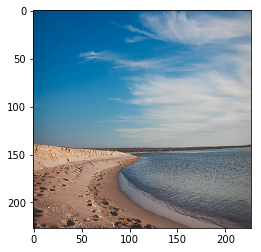

In [27]:
batch_index = 8
image = style_data_batch[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', style_labels[style_label_batch[batch_index]]

In [28]:
disp_imagenet_preds(imagenet_net, image)

top 5 predicted ImageNet labels =
	(1) 69.89% n09421951 sandbar, sand bar
	(2) 21.76% n09428293 seashore, coast, seacoast, sea-coast
	(3)  3.22% n02894605 breakwater, groin, groyne, mole, bulwark, seawall, jetty
	(4)  1.89% n04592741 wing
	(5)  1.23% n09332890 lakeside, lakeshore


In [29]:
disp_style_preds(untrained_style_net, image)

top 5 predicted style labels =
	(1) 20.00% Detailed
	(2) 20.00% Pastel
	(3) 20.00% Melancholy
	(4) 20.00% Noir
	(5) 20.00% HDR


In [30]:
diff = untrained_style_net.blobs['fc7'].data[0] - imagenet_net.blobs['fc7'].data[0]
error = (diff ** 2).sum()
assert error < 1e-8

In [31]:
del untrained_style_net

# Training the style classifier

In [38]:
from caffe.proto import caffe_pb2
def solver(train_net_path,test_net_path=None,base_lr=0.001):
    s = caffe_pb2.SolverParameter()
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000
        s.test_iter.append(1000)
    
    s.iter_size=1
    s.max_iter=100000
    
    s.type="SGD"
    
    s.base_lr = base_lr
    
    s.lr_policy = "step"
    s.gamma = 0.1
    s.stepsize = 20000
    
    s.momentum=0.9
    s.weight_decay=5e-4
    
    s.display=1000
    s.snapshot=10000
    s.snapshot_prefix = caffe_root+"models/finetune_flickr_style/finetune_flickr_style"
    
    s.solver_mode = caffe_pb2.SolverParameter.CPU
    
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

In [43]:
def run_solvers(niter,solvers,disp_interval=10):
    blobs = ("loss","acc")
    loss,acc = ({name:np.zeros(niter) for name,_ in solvers} for _ in blobs)
    
    for it in range(niter):
        for name, s in solvers:
            s.step(1)
            loss[name][it],acc[name][it] = (s.net.blobs[b].data.copy() for b in blobs)
            
        if it % disp_interval == 0 or it+1==niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print("%3d) %s" % (it,loss_disp))
    
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = "weights.%s.caffemodel"%name
        weights[name] = os.path.join(weight_dir,filename)
        s.net.save(weights[name])
        return loss,acc,weights

In [44]:
niter = 200

style_solver_filename = solver(style_net(train=True))
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(weights)

scratch_style_solver_filename = solver(style_net(train=True))
scaratch_style_solver = caffe.get_solver(scratch_style_solver_filename)


In [45]:
print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', style_solver),]
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

Running solvers for 200 iterations...
  0) pretrained: loss=1.609, acc=28%
 10) pretrained: loss=1.390, acc=48%
 20) pretrained: loss=1.156, acc=62%
 30) pretrained: loss=0.919, acc=64%
 40) pretrained: loss=0.924, acc=64%
 50) pretrained: loss=1.074, acc=56%
 60) pretrained: loss=0.920, acc=52%
 70) pretrained: loss=0.748, acc=76%
 80) pretrained: loss=0.752, acc=68%
 90) pretrained: loss=1.077, acc=60%
100) pretrained: loss=0.842, acc=70%
110) pretrained: loss=0.818, acc=70%
120) pretrained: loss=0.819, acc=70%
130) pretrained: loss=0.998, acc=60%
140) pretrained: loss=1.061, acc=62%
150) pretrained: loss=0.590, acc=80%
160) pretrained: loss=1.043, acc=62%
170) pretrained: loss=1.056, acc=60%
180) pretrained: loss=0.778, acc=66%
190) pretrained: loss=0.931, acc=62%
199) pretrained: loss=0.994, acc=70%
Done.


In [46]:
def eval_style_net(weights, test_iters=10):
    test_net = caffe.Net(style_net(train=False), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [54]:
train_loss= loss['pretrained']
train_acc = acc['pretrained']
style_weights = weights['pretrained']
# Delete solvers to save memory.
del style_solver, solvers

NameError: name 'solvers' is not defined

In [51]:
test_net, accuracy = eval_style_net(style_weights)
print 'Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )

Accuracy, trained from ImageNet initialization: 52.2%


In [57]:
end_to_end_net = style_net(train=True,learn_all=True)
base_lr = 0.001

style_solver_filename = solver(end_to_end_net,base_lr = base_lr)
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(style_weights)
solvers = [('pretrained, end-to-end', style_solver),]
_, _, finetuned_weights = run_solvers(niter, solvers)
print 'Done.'

  0) pretrained, end-to-end: loss=0.807, acc=72%
 10) pretrained, end-to-end: loss=1.264, acc=62%
 20) pretrained, end-to-end: loss=0.926, acc=62%
 30) pretrained, end-to-end: loss=0.691, acc=76%
 40) pretrained, end-to-end: loss=0.671, acc=72%
 50) pretrained, end-to-end: loss=0.856, acc=68%
 60) pretrained, end-to-end: loss=0.693, acc=66%
 70) pretrained, end-to-end: loss=0.660, acc=80%
 80) pretrained, end-to-end: loss=0.645, acc=74%
 90) pretrained, end-to-end: loss=0.737, acc=66%
100) pretrained, end-to-end: loss=0.722, acc=70%
110) pretrained, end-to-end: loss=0.630, acc=70%
120) pretrained, end-to-end: loss=0.665, acc=72%
130) pretrained, end-to-end: loss=0.601, acc=78%
140) pretrained, end-to-end: loss=0.589, acc=78%
150) pretrained, end-to-end: loss=0.377, acc=78%
160) pretrained, end-to-end: loss=0.535, acc=78%
170) pretrained, end-to-end: loss=0.368, acc=82%
180) pretrained, end-to-end: loss=0.462, acc=84%
190) pretrained, end-to-end: loss=0.422, acc=84%
199) pretrained, end

In [58]:
style_weights_ft = finetuned_weights['pretrained, end-to-end']

# Delete solvers to save memory.
del style_solver, solvers

In [59]:
test_net, accuracy = eval_style_net(style_weights_ft)
print 'Accuracy, finetuned from ImageNet initialization: %3.1f%%' % (100*accuracy, )

Accuracy, finetuned from ImageNet initialization: 56.2%


top 5 predicted style labels =
	(1) 99.54% Melancholy
	(2)  0.26% Pastel
	(3)  0.16% HDR
	(4)  0.03% Detailed
	(5)  0.00% Noir


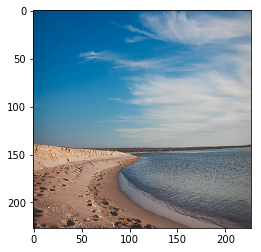

In [60]:
plt.imshow(deprocess_net_image(image))
disp_style_preds(test_net, image)

actual label = Pastel


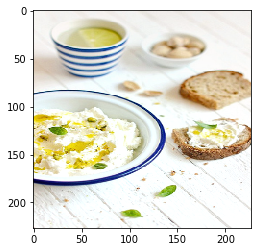

In [61]:
batch_index = 1
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', style_labels[int(test_net.blobs['label'].data[batch_index])]

In [62]:
disp_style_preds(test_net, image)

top 5 predicted style labels =
	(1) 99.97% Pastel
	(2)  0.02% Detailed
	(3)  0.00% HDR
	(4)  0.00% Melancholy
	(5)  0.00% Noir


In [63]:
disp_imagenet_preds(imagenet_net, image)

top 5 predicted ImageNet labels =
	(1) 34.90% n07579787 plate
	(2) 21.63% n04263257 soup bowl
	(3) 17.75% n07875152 potpie
	(4)  5.72% n07711569 mashed potato
	(5)  5.27% n07584110 consomme
